## autoencoder 

>自编码器（autoencoder, AE）是一类在半监督学习和非监督学习中使用的人工神经网络（Artificial Neural Networks, ANNs），其功能是通过将输入信息作为学习目标，对输入信息进行表征学习（representation learning） [1-2]  。
自编码器包含编码器（encoder）和解码器（decoder）两部分 [2]  。按学习范式，自编码器可以被分为收缩自编码器（contractive autoencoder）、正则自编码器（regularized autoencoder）和变分自编码器（Variational AutoEncoder, VAE），其中前两者是判别模型、后者是生成模型 [2]  。按构筑类型，自编码器可以是前馈结构或递归结构的神经网络。
自编码器具有一般意义上表征学习算法的功能，被应用于降维（dimensionality reduction）和异常值检测（anomaly detection） [2]  。包含卷积层构筑的自编码器可被应用于计算机视觉问题，包括图像降噪（image denoising） [3]  、神经风格迁移（neural style transfer）等 [4]  。

- 降维
- 用于无监督学习数据
- 压缩、去噪、超分辨率...

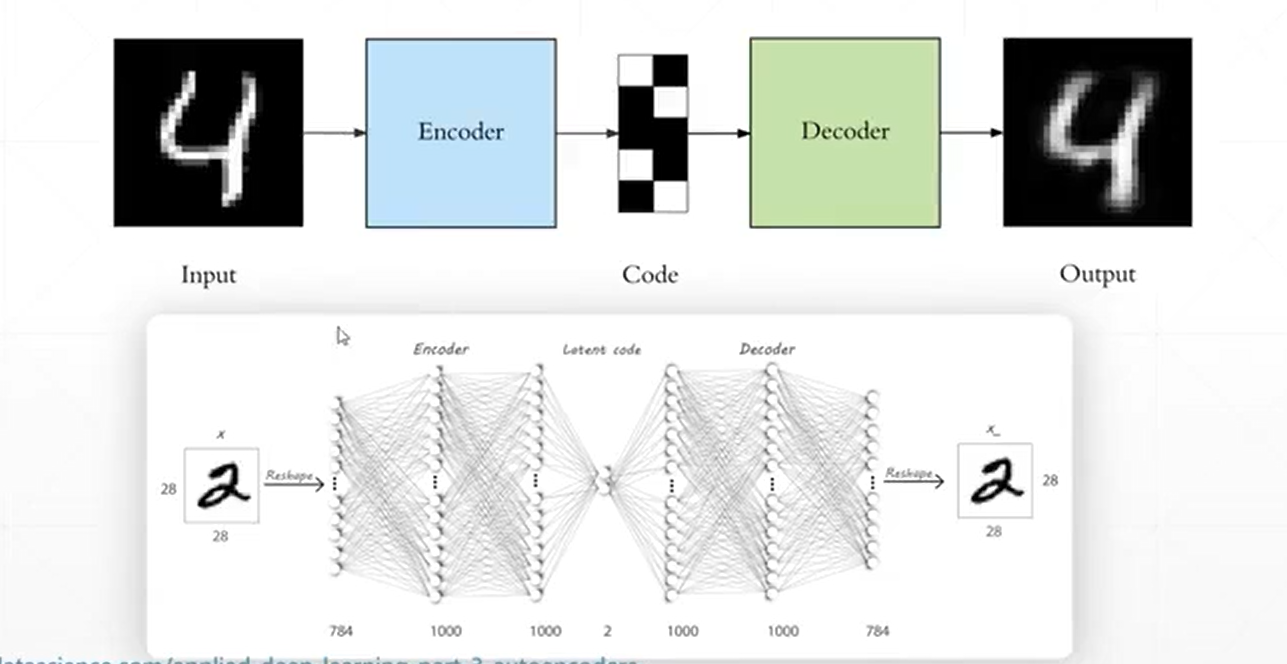

如何训练：
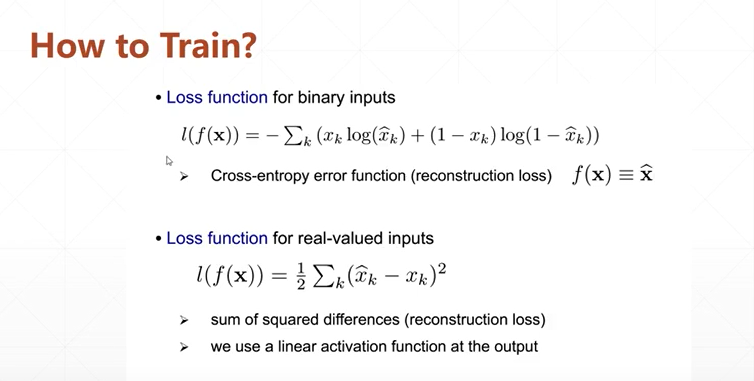

### 变种：
- Denosing AutoEncoder
    - 加入扰动层：加入扰动之后还能重建，说明网络能发掘比较高层次的特征
 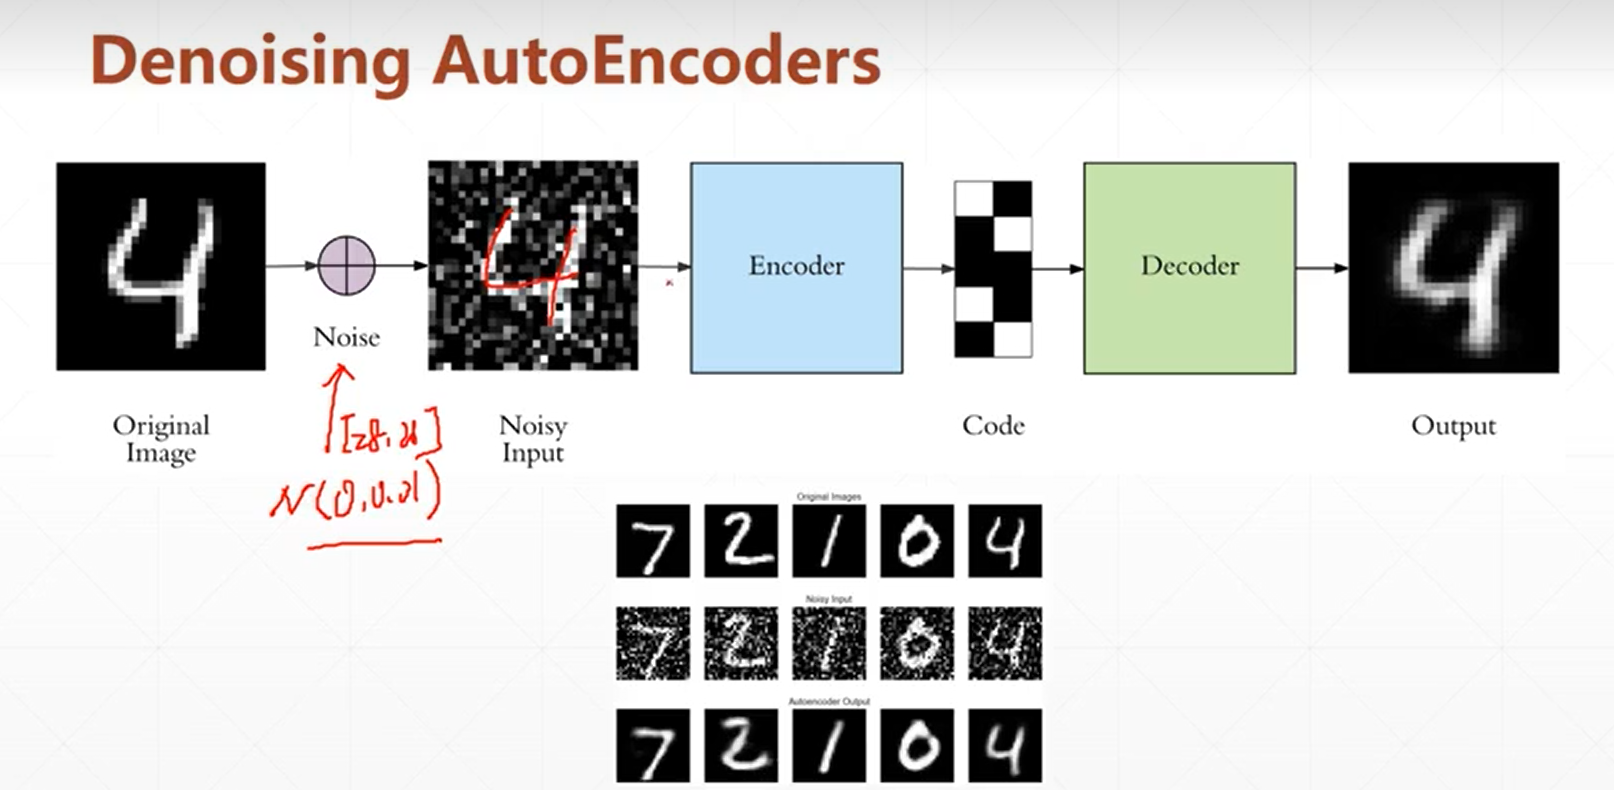
- Droupout AutoEncoder
    - 给你的信息有限，迫使你提高自己的鲁棒性；dropout少量的话效果会比较好
- **Adversarial AutoEncoder**
使用鉴别器，使得隐藏层符合期望的分布
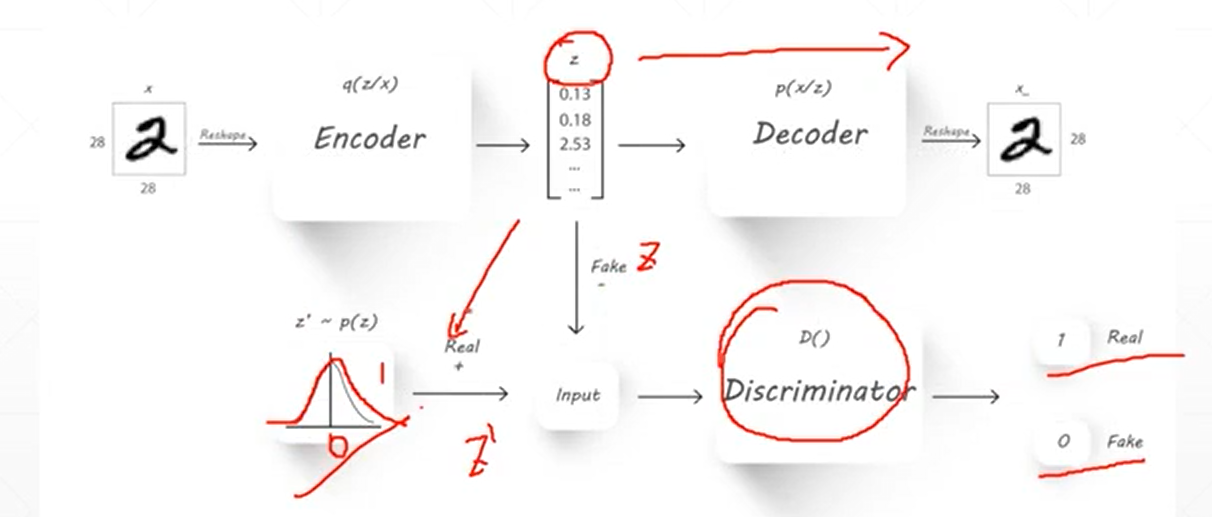

- **Variational Auto-Encoder**
    - 可以做生成的模型
    - 中间hidden层不一样，符合分布
    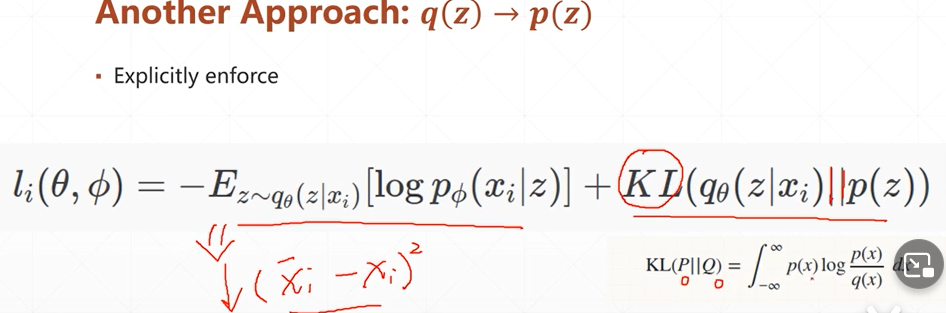
  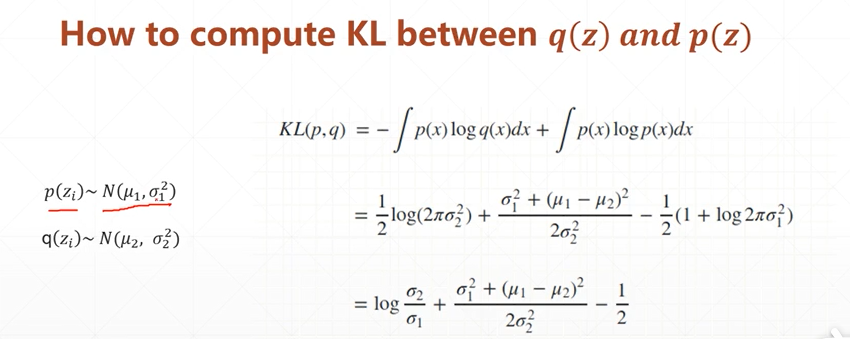

        - 然后对分布做采样再decode
        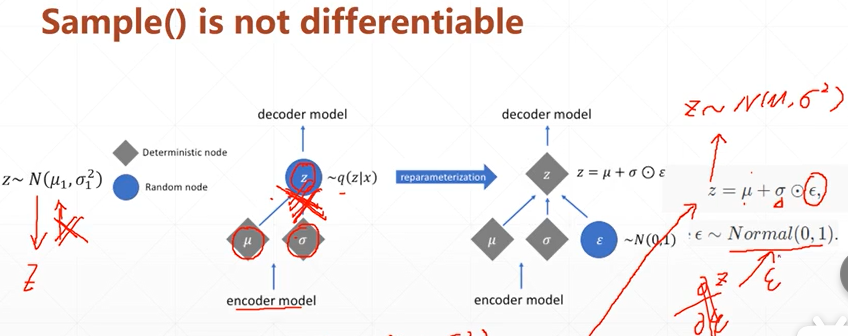
        - reparameterizaiton trick
    - 效果没有GAN好
  

### 实战

#### AutoEncoder

In [ ]:
#autoencoder.py
import torch
from torch import nn
from torch.nn import functional as F

class AE(nn.Module):

    def __init__(self):
        super(AE, self).__init__()
        #[b,784] => [b,20]
        self.encoder = nn.Sequential(
            nn.Linear(784,256),
            nn.ReLU(),
            nn.Linear(256,64),
            nn.ReLU(),
            nn.Linear(64,20),
            nn.ReLU()
        )
        #[b,20] => [b,784]
        self.decoder = nn.Sequential(
            nn.Linear(20,64),
            nn.ReLU(),
            nn.Linear(64,256),
            nn.ReLU(),
            nn.Linear(256,784),
            nn.Sigmoid()
        )

    def forward(self,x):
        """

        :param x:[b,1,28,28]
        :return:
        """

        batchsz = x.shape[0]
        flatten = nn.Flatten()
        x = flatten(x)
       # x = x.view(batchsz,784)
        #encoder
        x = self.encoder(x)
        #decoder
        x = self.decoder(x)
        #reshape
        x = x.view(batchsz,1,28,28)
        return x


In [ ]:
import torch
from  torch.utils.data import DataLoader
from torch import nn,optim
from torchvision import transforms,datasets

from autoencoder import AE#autoencode.py

import  visdom
def main():
    mnist_train = datasets.MNIST("./all/ai_pytorch/mnist data",True,transform=transforms.Compose([
        transforms.ToTensor()
    ]),download=True)

    mnist_train = DataLoader(mnist_train,batch_size=32,shuffle=True)

    mnist_test = datasets.MNIST("./all/ai_pytorch/mnist data", False, transform=transforms.Compose([
        transforms.ToTensor()
    ]), download=True)

    mnist_test = DataLoader(mnist_test, batch_size=32, shuffle=True)

    x,_ = iter(mnist_train).next()
    print('x:',x.shape)

    device = torch.device("cuda:0")
    model = AE().to(device)
 
    criteon = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(),lr=1e-3)
    print(model)
    viz = visdom.Visdom()
    for epoch in range(1000):
        for batchidx,(x,_) in enumerate(mnist_train):
            x =x.to(device)
            x_hat = model(x)
            loss = criteon(x_hat,x)

            #backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(epoch,'loss:',loss.item())
       

        x, _ = iter(mnist_test).next()
        x = x.to(device)
        with torch.no_grad():
            x_hat = model(x)
       
        viz.images(x,nrow=8,win='x',opts=dict(title='x' ))
        viz.images(x_hat, nrow=8, win='x_hat', opts=dict(title='x_hat'))


if __name__ == '__main__':
    main()

#### VAE

In [ ]:
#vae.py
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
class VAE(nn.Module):

    def __init__(self):
        super(VAE, self).__init__()
        #[b,784] => [b,20]
        # u:[b,10]
        # sigema:[b,10]
        self.encoder = nn.Sequential(
            nn.Linear(784,256),
            nn.ReLU(),
            nn.Linear(256,64),
            nn.ReLU(),
            nn.Linear(64,20),
            nn.ReLU()
        )
        #[b,10] => [b,784] #输入由原来的20变成10，因为做了拆分
        self.decoder = nn.Sequential(
            nn.Linear(10,64),
            nn.ReLU(),
            nn.Linear(64,256),
            nn.ReLU(),
            nn.Linear(256,784),
            nn.Sigmoid()
        )
        self.criteon = nn.MSELoss()

    def forward(self,x):
        """

        :param x:[b,1,28,28]
        :return:
        """

        batchsz = x.shape[0]
        flatten = nn.Flatten()
        x = flatten(x)
       # x = x.view(batchsz,784)

        #encoder
        # [b,20],including mean and sigma
        h_ = self.encoder(x)
        # [b,20] =>[b,10],[b,10]
        mu,sigma = h_.chunk(2,dim=1)
        #reparameterize trick epison~N(0,1)
        h = mu+sigma*torch.randn_like(sigma)#randn是正态分布
        #
        kld = 0.5 * torch.sum(
            torch.pow(mu,2)+torch.pow(sigma,2)-
            torch.log(1e-8+torch.pow(sigma,2))-1
                #1e-8进行log的限幅，防止x接近0的时候，log负无穷大
        )/np.prod(x.shape)#每个像素上的kld

        #decoder
        x_hat = self.decoder(h)
        #reshape
        x_hat = x_hat.view(batchsz,1,28,28)
        return x_hat,kld


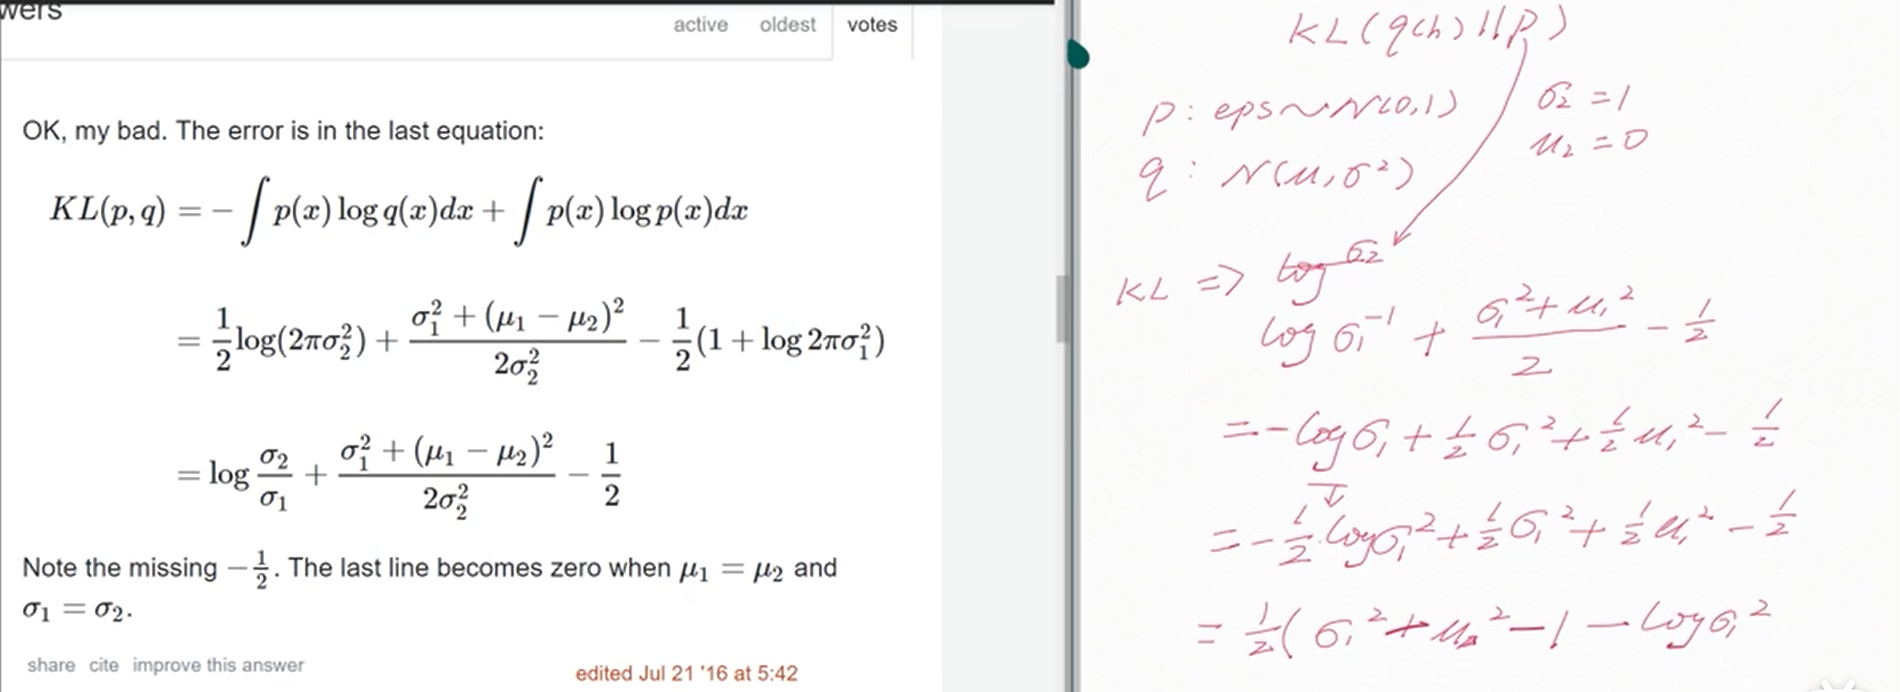

In [ ]:
import torch
from  torch.utils.data import DataLoader
from torch import nn,optim
from torchvision import transforms,datasets

from autoencoder import AE
from vae import VAE
import  visdom
def main():
    mnist_train = datasets.MNIST("./all/ai_pytorch/mnist data",True,transform=transforms.Compose([
        transforms.ToTensor()
    ]),download=True)

    mnist_train = DataLoader(mnist_train,batch_size=32,shuffle=True)

    mnist_test = datasets.MNIST("./all/ai_pytorch/mnist data", False, transform=transforms.Compose([
        transforms.ToTensor()
    ]), download=True)

    mnist_test = DataLoader(mnist_test, batch_size=32, shuffle=True)

    x,_ = iter(mnist_train).next()
    print('x:',x.shape)

    device = torch.device("cuda:0")
    # model = AE().to(device)
    model = VAE().to(device)
    criteon = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(),lr=1e-3)
    print(model)
    viz = visdom.Visdom()
    for epoch in range(1000):
        for batchidx,(x,_) in enumerate(mnist_train):
            x =x.to(device)
            # x_hat = model(x)
            x_hat,kld = model(x)
            loss = criteon(x_hat,x)

            if kld is not None:
                elbo = -loss  - 1.0*kld
                loss = -elbo

            #backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # print(epoch,'loss:',loss.item())
        print(epoch, 'loss:', loss.item(),kld.item())

        x, _ = iter(mnist_test).next()
        x = x.to(device)
        with torch.no_grad():
            #x_hat = model(x)
            x_hat, kld = model(x)
        viz.images(x,nrow=8,win='x',opts=dict(title='x' ))
        viz.images(x_hat, nrow=8, win='x_hat', opts=dict(title='x_hat'))


if __name__ == '__main__':
    main()